In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
# 서울 지하철 정보를 이용해서 다음을 구하고자 한다. 
#   - 노선별 연도별 연간 승하차 인원
#   - 노선별 연도별 월간 승하차 인원
#   - 1호선의 지하철역별 시간대별 유동인구

#  작업의 순서
#   1. 분석데이터 외관 확인
#      1.1 seoul_metro.csv 를 metro로 load  (코드제공)
#      1.2 메타데이터의 확인, (코드제공)
#      1.3 메모리 조정을 수행한다. 
#
#   2. Tidy 한 형태로 데이터를 정비
#       2.1 컬럼명의 변경
#       2.2 중복컬럼의 제거
#       2.3  wide_to_long 이용 데이터 재구성
#       2.4  stack이용 데이터 재구성
#       2.5 필요한 컬럼의 추가 및 컬럼 순서 정리
#       2.6 컬럼 메모리 재조정
#
#   3. 분석 수행
#      3.1 노선별 연도별 연간 승하차 인원
#      3.2 노선별 연도별 월간 승하차 인원
#      3.3 1호선의 지하철역별 시간대별 유동인구

# 1. 분석데이터 외관 확인

In [3]:
# 1.1
# 서울 지하철 승하차와 관련된 데이터 분석을 위해, metro 로 load 하고 tidy data로 정리해본다.
# 우선 현재 데이터 상태를 살펴본다.

In [4]:
metro = pd.read_csv('data/seoul_metro.csv',encoding = 'euc-kr')
metro.tail(3)

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
34500,201501,4호선,미아,12,1,10667,1812,23354,5827,64853,...,21422,705,5150,0,0,0,0,0,0,20151223
34501,201501,4호선,쌍문,38,0,22176,860,56130,10585,149688,...,53418,987,15401,0,0,1,0,0,0,20151223
34502,201501,4호선,창동,1639,4,15337,3564,42523,12352,111102,...,49766,2401,16976,3,33,0,1,0,0,20151223


In [5]:
# 1.2
# 34503 행, 52컬럼
metro.shape

(34503, 52)

In [6]:
# 16M 로 데이터 사이즈가 크다
# 누락값은 없는 듯하다. (int type 으로 데이터가 읽어 들여졌다.)
# 24시간 x 승차하차 구분 = 48개의 승하차 인원 컬럼이 있다. 
# 승하차 인원 컬럼이 아닌 4개 (52-48)의 컬럼은  사용월, 호선명, 지하철역, 작업일자 이다. 
metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34503 entries, 0 to 34502
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           34503 non-null  int64 
 1   호선명           34503 non-null  object
 2   지하철역          34503 non-null  object
 3   04시-05시 승차인원  34503 non-null  int64 
 4   04시-05시 하차인원  34503 non-null  int64 
 5   05시-06시 승차인원  34503 non-null  int64 
 6   05시-06시 하차인원  34503 non-null  int64 
 7   06시-07시 승차인원  34503 non-null  int64 
 8   06시-07시 하차인원  34503 non-null  int64 
 9   07시-08시 승차인원  34503 non-null  int64 
 10  07시-08시 하차인원  34503 non-null  int64 
 11  08시-09시 승차인원  34503 non-null  int64 
 12  08시-09시 하차인원  34503 non-null  int64 
 13  09시-10시 승차인원  34503 non-null  int64 
 14  09시-10시 하차인원  34503 non-null  int64 
 15  10시-11시 승차인원  34503 non-null  int64 
 16  10시-11시 하차인원  34503 non-null  int64 
 17  11시-12시 승차인원  34503 non-null  int64 
 18  11시-12시 하차인원  34503 non-null  int64 
 19  12시-

In [7]:
# 누락값 없는지 확인사살
metro.isnull().any().any()

False

In [8]:
# 사용월을 보면 201501 ~ 201912 5년 (=60개월)의 정보가 있다.
metro.describe().T

,count,mean,std,min,25%,50%,75%,max
사용월,34503.0,2.017106e+05,141.431177,201501.0,201604.0,201707.0,201810.0,201912.0
04시-05시 승차인원,34503.0,1.985590e+02,638.753864,0.0,3.0,20.0,108.0,13585.0
04시-05시 하차인원,34503.0,2.925543e+00,7.518705,0.0,0.0,0.0,3.0,170.0
05시-06시 승차인원,34503.0,5.514649e+03,6386.322710,0.0,1544.0,3651.0,7066.0,59655.0
05시-06시 하차인원,34503.0,1.371890e+03,1536.901900,0.0,398.0,939.0,1730.0,15843.0
06시-07시 승차인원,34503.0,1.136755e+04,11199.707646,0.0,3641.5,8099.0,15282.0,99232.0
06시-07시 하차인원,34503.0,7.516324e+03,8108.698413,0.0,2455.0,5155.0,9563.0,87300.0
07시-08시 승차인원,34503.0,2.995111e+04,30871.392809,0.0,8541.0,20668.0,40673.0,294593.0
07시-08시 하차인원,34503.0,1.725638e+04,22062.599490,0.0,4912.0,10128.0,20413.5,238513.0
08시-09시 승차인원,34503.0,3.407603e+04,35998.750152,0.0,10596.0,23881.0,45228.5,386398.0


In [9]:
# 승하차 인원이 관련된 컬럼의 정보 확인
# describe().T.describe()를 통해, 승하차의 최대 최소값을 확인해 둔다.
# 최소  0,  최대 465,406  ==> 2**32 = 4294967296 보다 작으므로 int32로 관리 가능하다
metro.filter(like = '인원').describe().T.describe()

,count,mean,std,min,25%,50%,75%,max
count,48.0,48.000000,48.000000,48.0,48.000000,48.000000,48.000000,48.000000
mean,34503.0,16072.831389,18577.706363,0.0,4848.447917,10426.833333,19953.229167,182691.020833
std,0.0,11101.428362,13359.280621,0.0,3366.468110,7272.752692,13652.261145,127218.292608
min,34503.0,0.020984,0.784627,0.0,0.000000,0.000000,0.000000,94.000000
25%,34503.0,6500.796525,7678.104487,0.0,1447.750000,3452.250000,7366.000000,80388.750000
50%,34503.0,17644.671797,20064.948453,0.0,5604.000000,11908.000000,21870.750000,196239.000000
75%,34503.0,21498.100194,25361.128068,0.0,7067.625000,14055.250000,27065.875000,248361.000000
max,34503.0,39929.024867,55320.214420,0.0,11359.500000,24177.000000,45297.500000,465406.000000


In [10]:
# 호선명, 지하철역도 데이터 행의 개수에 비하면 26개, 563개로 unique한 값이 작으므로 
# 카테고리 변수화 가능하다. 
metro.describe(include = 'object')

,호선명,지하철역
count,34503,34503
unique,26,563
top,5호선,서울역
freq,3060,334


In [11]:
# 사용월과 작업일자도 카테고리 변수화 대상이다. 
metro.작업일자.nunique(), metro.사용월.nunique()

(51, 60)

In [12]:
# 1.3
#   16M로 제법 데이터가 크다. 
#    사용월, 호선명, 지하철역, 작업일자를 카테고리 변수로 변경한다
#    승차인원/하차인원 관련 컬럼을 int32로 변경한다.  
#   hint1 : Week2 slide page5 참조
#   hint2 : 컬럼명 리스트를 만들어 놓는다. ex) all_cols, psn_cols, cat_cols 

In [13]:
# 컬럼명 목록 정리

all_cols = metro.columns
int_cols = ['04시-05시 승차인원', '04시-05시 하차인원', '05시-06시 승차인원',
       '05시-06시 하차인원', '06시-07시 승차인원', '06시-07시 하차인원', '07시-08시 승차인원',
       '07시-08시 하차인원', '08시-09시 승차인원', '08시-09시 하차인원', '09시-10시 승차인원',
       '09시-10시 하차인원', '10시-11시 승차인원', '10시-11시 하차인원', '11시-12시 승차인원',
       '11시-12시 하차인원', '12시-13시 승차인원', '12시-13시 하차인원', '13시-14시 승차인원',
       '13시-14시 하차인원', '14시-15시 승차인원', '14시-15시 하차인원', '15시-16시 승차인원',
       '15시-16시 하차인원', '16시-17시 승차인원', '16시-17시 하차인원', '17시-18시 승차인원',
       '17시-18시 하차인원', '18시-19시 승차인원', '18시-19시 하차인원', '19시-20시 승차인원',
       '19시-20시 하차인원', '20시-21시 승차인원', '20시-21시 하차인원', '21시-22시 승차인원',
       '21시-22시 하차인원', '22시-23시 승차인원', '22시-23시 하차인원', '23시-24시 승차인원',
       '23시-24시 하차인원', '00시-01시 승차인원', '00시-01시 하차인원', '01시-02시 승차인원',
       '01시-02시 하차인원', '02시-03시 승차인원', '02시-03시 하차인원', '03시-04시 승차인원',
       '03시-04시 하차인원']
cat_cols = ['사용월', '호선명', '지하철역','작업일자']

In [14]:
int_dict={i: 'int32' for i in int_cols}
cat_dict={i: 'category' for i in cat_cols}

In [15]:
# 카테고리 변수화
metro = metro.astype(cat_dict)

In [16]:
# 데이터 형 int32로 변경
metro = metro.astype(int_dict)

In [17]:
# 변경된 데이터 확인 --> 6.5M 로 변경 되었다.
metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34503 entries, 0 to 34502
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   사용월           34503 non-null  category
 1   호선명           34503 non-null  category
 2   지하철역          34503 non-null  category
 3   04시-05시 승차인원  34503 non-null  int32   
 4   04시-05시 하차인원  34503 non-null  int32   
 5   05시-06시 승차인원  34503 non-null  int32   
 6   05시-06시 하차인원  34503 non-null  int32   
 7   06시-07시 승차인원  34503 non-null  int32   
 8   06시-07시 하차인원  34503 non-null  int32   
 9   07시-08시 승차인원  34503 non-null  int32   
 10  07시-08시 하차인원  34503 non-null  int32   
 11  08시-09시 승차인원  34503 non-null  int32   
 12  08시-09시 하차인원  34503 non-null  int32   
 13  09시-10시 승차인원  34503 non-null  int32   
 14  09시-10시 하차인원  34503 non-null  int32   
 15  10시-11시 승차인원  34503 non-null  int32   
 16  10시-11시 하차인원  34503 non-null  int32   
 17  11시-12시 승차인원  34503 non-null  int32   
 18  11시-12

#   2. Tidy 한 형태로 데이터를 정비

# 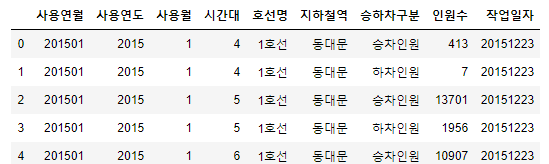

In [18]:
#  2.1 컬럼명의 변경
#  2.2 중복컬럼의 제거
#  2.3  wide_to_long 이용 데이터 재구성
#  2.4  stack이용 데이터 재구성
#  2.5 필요한 컬럼의 추가 및 컬럼 순서 정리
#  2.6 컬럼 메모리 재조정

In [19]:
# 2.1 컬럼명의 변경
#    승차인원 / 하차인원을 stub로 하여 wide_to_long을 진행하고자 한다. 
#    변수명을 다음과 같이 변경한다.
#    '04시-05시 승차인원'  ==> '승차인원_04'
#     hint : 실습 8.3 참조  (함수 정의 및 rename) , 다른 방법도 가능

In [20]:
def change_col_name(col_name):
    if col_name not in cat_cols:
        col_name = col_name[8:]+'_'+col_name[:2]
    return col_name

In [21]:
metro2 = metro.rename(columns = change_col_name)
metro2.head()

,사용월,호선명,지하철역,승차인원_04,하차인원_04,승차인원_05,하차인원_05,승차인원_06,하차인원_06,승차인원_07,...,하차인원_23,승차인원_00,하차인원_00,승차인원_01,하차인원_01,승차인원_02,하차인원_02,승차인원_03,하차인원_03,작업일자
0,201912,중앙선,원덕,23,0,299,5,460,68,1198,...,393,3,268,1,0,0,0,0,0,20200103
1,201912,중앙선,지평,0,0,0,0,0,0,298,...,0,0,1,0,0,0,0,0,0,20200103
2,201912,중앙선,양평,49,9,1316,65,2384,1560,9299,...,5001,135,1717,3,3,0,0,0,0,20200103
3,201912,중앙선,용문,264,4,966,10,2328,432,3692,...,2249,0,1069,0,23,0,0,0,0,20200103
4,201912,1호선,서울역,1042,21,10804,8783,13452,49937,40767,...,22452,4110,8914,49,1604,0,66,0,0,20200103


In [22]:
# 2.2 중복컬럼의 제거
#     pd.wide_to_long의 id_vars는 unique한 값만 처리 할 수 있다. 
#     sort --> drop_duplicate
#    사용월, 호선명, 지하철역, 작업일자 및 승차인원_07을 정렬한다. 
#        metro.sort_values(by = ....
#                      ascending = [True, True, True, True, False])
#        dropduplicte(subset = ... )
#     중복 제거 전에 정렬을 하는데  적당히 승차인원이 많아지는 시간대를 기준으로 
#     내림 차순 정렬
#     중복이 제거된 데이터를 metro2에 저장한다. 




In [23]:
metro2 = metro2.sort_values(by = ['사용월', '호선명', '지하철역', '작업일자','승차인원_07'], ascending = [True, True, True, True, False]).drop_duplicates(subset =  ['사용월', '호선명', '지하철역', '작업일자'])

In [24]:
# 2.3  wide_to_long 이용 데이터 재구성
#    wide_to_long 함수를 적용하여 데이터를 정돈하여 metro3에 저장한다. 
#       04 와 같이 변수화 되는 컬럼명은 '시간대'로 한다. 
#       stub = ['승차인원','하차인원']

In [25]:
metro3 = pd.wide_to_long(metro2, stubnames = ['승차인원','하차인원'], i =  ['사용월', '호선명', '지하철역', '작업일자'] , j = '시간대', sep = '_')

In [26]:
metro3

승차인원   하차인원
사용월    호선명 지하철역 작업일자     시간대              
201501 1호선 동대문  20151223 4      413      7
                         5    13701   1956
                         6    10907   7588
                         7    16633  13326
                         8    25485  31619
...                             ...    ...
201912 중앙선 회기   20200103 23   20850  36447
                         0     1356  10693
                         1        2    322
                         2        0      0
                         3        0      0

[826272 rows x 2 columns]

In [27]:
#  2.4  stack이용 데이터 재구성
#       stack () 을 이용해서 승차인원, 하차인원을 stack 하고 
#       '승하차구분', '인원수' 컬럼으로 정리한다. 
#       정리된 데이터를 metro_tidy에 저장한다


In [28]:
metro_tidy = metro3.stack().reset_index().rename(columns = {'level_5':'승하차구분',0:'인원수'})
metro_tidy.head()

,사용월,호선명,지하철역,작업일자,시간대,승하차구분,인원수
0,201501,1호선,동대문,20151223,4,승차인원,413
1,201501,1호선,동대문,20151223,4,하차인원,7
2,201501,1호선,동대문,20151223,5,승차인원,13701
3,201501,1호선,동대문,20151223,5,하차인원,1956
4,201501,1호선,동대문,20151223,6,승차인원,10907


In [29]:
# 2.5 필요한 컬럼의 추가 및 컬럼 순서 정리
#     연도별 , 월별 분석이 가능하도록 컬럼을 정리한다. 
#       사용연월  : 201501
#       사용연도 : 2015
#       사용월  : 1
#      column 순서를 정리한다. 
#      컬럼추가에  .apply,  lambda 함수 사용   -->  .apply(lambda x : ...)

In [30]:
metro_tidy['사용월']=metro_tidy['사용월'].astype(str)
metro_tidy = metro_tidy.rename(columns = {'사용월':'사용연월'})

In [31]:
metro_tidy['사용연도'] = metro_tidy['사용연월'].apply(lambda x:x[:4])
metro_tidy['사용월'] = metro_tidy['사용연월'].apply(lambda x:x[4:])

In [32]:
metro_tidy = metro_tidy[['사용연월','사용연도','사용월','시간대','호선명','지하철역','승하차구분','인원수','작업일자']]
metro_tidy.head()

,사용연월,사용연도,사용월,시간대,호선명,지하철역,승하차구분,인원수,작업일자
0,201501,2015,01,4,1호선,동대문,승차인원,413,20151223
1,201501,2015,01,4,1호선,동대문,하차인원,7,20151223
2,201501,2015,01,5,1호선,동대문,승차인원,13701,20151223
3,201501,2015,01,5,1호선,동대문,하차인원,1956,20151223
4,201501,2015,01,6,1호선,동대문,승차인원,10907,20151223


In [33]:
#  2.6컬럼 메모리 재조정
#   사용연도, 사용월, 시간대, 승하차구분 컬럼의 데이터 타입을 category로 정리한다. 

In [34]:
tmp_dict = {i:'category' for i in ['사용연월','사용연도', '사용월', '시간대', '승하차구분']}

In [35]:
metro_tidy = metro_tidy.astype(tmp_dict)

In [36]:
metro_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652544 entries, 0 to 1652543
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype   
---  ------  --------------    -----   
 0   사용연월    1652544 non-null  category
 1   사용연도    1652544 non-null  category
 2   사용월     1652544 non-null  category
 3   시간대     1652544 non-null  category
 4   호선명     1652544 non-null  category
 5   지하철역    1652544 non-null  category
 6   승하차구분   1652544 non-null  category
 7   인원수     1652544 non-null  int32   
 8   작업일자    1652544 non-null  category
dtypes: category(8), int32(1)
memory usage: 20.5 MB


In [37]:
# Tidy하게 정돈 완료한 데이터 
metro_tidy.head()

,사용연월,사용연도,사용월,시간대,호선명,지하철역,승하차구분,인원수,작업일자
0,201501,2015,01,4,1호선,동대문,승차인원,413,20151223
1,201501,2015,01,4,1호선,동대문,하차인원,7,20151223
2,201501,2015,01,5,1호선,동대문,승차인원,13701,20151223
3,201501,2015,01,5,1호선,동대문,하차인원,1956,20151223
4,201501,2015,01,6,1호선,동대문,승차인원,10907,20151223


#   3. 분석 수행

In [ ]:
# 3.1 노선별 연도별 연간 승하차 인원
# 3.2 노선별 연도별 월간 승하차 인원
# 3.3 1호선의 지하철역별 시간대별 유동인구

In [ ]:
# 3.1 노선별 연도별 연간 승하차 인원

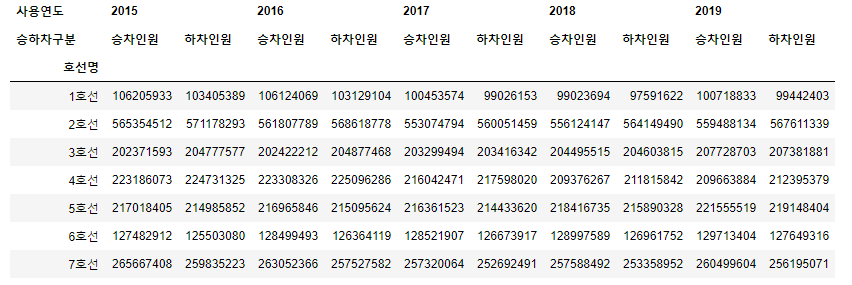

In [88]:
pd.pivot_table(metro_tidy, index = '호선명', values = '인원수', columns =['사용연도','승하차구분'], aggfunc = 'sum').fillna(0).astype(int)

사용연도           2015                  2016                  2017             \
승하차구분          승차인원       하차인원       승차인원       하차인원       승차인원       하차인원   
호선명                                                                          
1호선       106205933  103405389  106124069  103129104  100453574   99026153   
2호선       565354512  571178293  561807789  568618778  553074794  560051459   
3호선       202371593  204777577  202422212  204877468  203299494  203416342   
4호선       223186073  224731325  223308326  225096286  216042471  217598020   
5호선       217018405  214985852  216965846  215095624  216361523  214433620   
6호선       127482912  125503080  128499493  126364119  128521907  126673917   
7호선       265667408  259835223  263052366  257527582  257320064  252692491   
8호선        60205562   59140668   61758240   60873303   64617800   64133479   
9호선        93794551   93062513   94530872   94514407   94908282   96554655   
9호선2~3단계          0          0          0          0          0          0   
9호선2단계      7762635    7463770   12967731   12530599   14047371   13648471   
경강선               0          0    2151969    1971227    8616149    8082180   
경부선       185632977  186364183  178598690  179155588  176789571  175769748   
경원선        81638040   79688922   81703560   79493886   80850623   78398256   
경의선        31859270   31031507   34844784   33928106   36740090   35639918   
경인선       126550354  124761067  125381629  123260137  122068187  119728692   
경춘선        13636363   13322018   13922315   13495550   14424294   13847838   
공항철도 1호선   33185644   30220586   34290426   30862734   34774867   31780240   
과천선        41203055   40376540   41395081   40141138   40745683   38948393   
분당선       131330833  135649519  129353196  133747978  130681885  135565399   
수인선        10075455   10095115   14808856   14952173   16806342   16857535   
안산선        49128399   48302403   48771301   47995101   48157716   47409137   
우이신설선             0          0          0          0    4579079    4486099   
일산선        37955481   36610716   39177686   37783499   40416912   38983207   
장항선         5628275    5408971    5611104    5377488    5758390    5479202   
중앙선        36630002   35825468   36916414   35998702   36396374   35450789   

사용연도           2018                  2019             
승하차구분          승차인원       하차인원       승차인원       하차인원  
호선명                                                   
1호선        99023694   97591622  100718833   99442403  
2호선       556124147  564149490  559488134  567611339  
3호선       204495515  204603815  207728703  207381881  
4호선       209376267  211815842  209663884  212395379  
5호선       218416735  215890328  221555519  219148404  
6호선       128997589  126961752  129713404  127649316  
7호선       257588492  253358952  260499604  256195071  
8호선        67318589   67116195   69740908   69670648  
9호선        95832595   97740191  100366261  102664812  
9호선2~3단계    2295574    2217791   30584049   29871278  
9호선2단계     13559002   13192264          0          0  
경강선         9559684    9021600   10330834    9842914  
경부선       176509118  175267298  178831162  177410925  
경원선        79766875   77186667   80284414   77692318  
경의선        37509515   36378290   39448811   38235268  
경인선       118909280  116735495  118394958  116177693  
경춘선        14197475   13628873   14525071   13915867  
공항철도 1호선   38747929   35667160   43168343   39624314  
과천선        40544369   38712914   40860939   39796953  
분당선       132592005  137384951  136292163  140820556  
수인선        16460856   16490589   16806916   16870959  
안산선        47492040   46806204   47412615   46757124  
우이신설선      15161328   14671195   16163995   15575959  
일산선        40884884   39464982   42039877   40483030  
장항선         5629417    5346032    5718641    5439688  
중앙선        35720146   34734365   36368017   35187091

In [ ]:
# 3.2 노선별 연도별 월간 승하차 인원
#     groupby를 사용해 원간 인원을 구한 다음 재집계 한다.

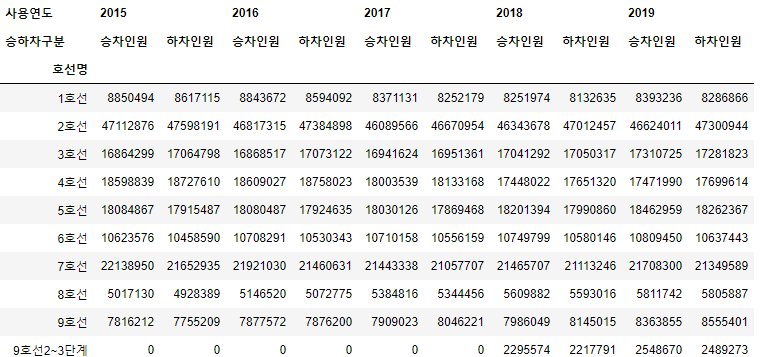

In [98]:
tmp1 = metro_tidy.groupby(['사용월','호선명','사용연도','승하차구분'])['인원수'].sum().reset_index()
tmp1

,사용월,호선명,사용연도,승하차구분,인원수
0,01,1호선,2015,승차인원,9420479.0
1,01,1호선,2015,하차인원,9127490.0
2,01,1호선,2016,승차인원,8789710.0
3,01,1호선,2016,하차인원,8492300.0
4,01,1호선,2017,승차인원,8256306.0
...,...,...,...,...,...
3115,12,중앙선,2017,하차인원,2899888.0
3116,12,중앙선,2018,승차인원,2921988.0
3117,12,중앙선,2018,하차인원,2827651.0
3118,12,중앙선,2019,승차인원,3037824.0


In [99]:
pd.pivot_table(tmp1, index = '호선명', values = '인원수', columns =['사용연도','승하차구분']).round().fillna(0).astype(int)

사용연도          2015                2016                2017            \
승하차구분         승차인원      하차인원      승차인원      하차인원      승차인원      하차인원   
호선명                                                                    
1호선        8850494   8617116   8843672   8594092   8371131   8252179   
2호선       47112876  47598191  46817316  47384898  46089566  46670955   
3호선       16864299  17064798  16868518  17073122  16941624  16951362   
4호선       18598839  18727610  18609027  18758024  18003539  18133168   
5호선       18084867  17915488  18080487  17924635  18030127  17869468   
6호선       10623576  10458590  10708291  10530343  10710159  10556160   
7호선       22138951  21652935  21921030  21460632  21443339  21057708   
8호선        5017130   4928389   5146520   5072775   5384817   5344457   
9호선        7816213   7755209   7877573   7876201   7909024   8046221   
9호선2~3단계         0         0         0         0         0         0   
9호선2단계      776264    746377   1080644   1044217   1170614   1137373   
경강선              0         0    537992    492807    718012    673515   
경부선       15469415  15530349  14883224  14929632  14732464  14647479   
경원선        6803170   6640744   6808630   6624490   6737552   6533188   
경의선        2654939   2585959   2903732   2827342   3061674   2969993   
경인선       10545863  10396756  10448469  10271678  10172349   9977391   
경춘선        1136364   1110168   1160193   1124629   1202024   1153986   
공항철도 1호선   2765470   2518382   2857536   2571894   2897906   2648353   
과천선        3433588   3364712   3449590   3345095   3395474   3245699   
분당선       10944236  11304127  10779433  11145665  10890157  11297117   
수인선         839621    841260   1234071   1246014   1400528   1404795   
안산선        4094033   4025200   4064275   3999592   4013143   3950761   
우이신설선            0         0         0         0   1144770   1121525   
일산선        3162957   3050893   3264807   3148625   3368076   3248601   
장항선         469023    450748    467592    448124    479866    456600   
중앙선        3052500   2985456   3076368   2999892   3033031   2954232   

사용연도          2018                2019            
승하차구분         승차인원      하차인원      승차인원      하차인원  
호선명                                               
1호선        8251974   8132635   8393236   8286867  
2호선       46343679  47012458  46624011  47300945  
3호선       17041293  17050318  17310725  17281823  
4호선       17448022  17651320  17471990  17699615  
5호선       18201395  17990861  18462960  18262367  
6호선       10749799  10580146  10809450  10637443  
7호선       21465708  21113246  21708300  21349589  
8호선        5609882   5593016   5811742   5805887  
9호선        7986050   8145016   8363855   8555401  
9호선2~3단계   2295574   2217791   2548671   2489273  
9호선2단계     1232637   1199297         0         0  
경강선         796640    751800    860903    820243  
경부선       14709093  14605608  14902597  14784244  
경원선        6647240   6432222   6690368   6474360  
경의선        3125793   3031524   3287401   3186272  
경인선        9909107   9727958   9866246   9681474  
경춘선        1183123   1135739   1210423   1159656  
공항철도 1호선   3228994   2972263   3597362   3302026  
과천선        3378697   3226076   3405078   3316413  
분당선       11049334  11448746  11357680  11735046  
수인선        1371738   1374216   1400576   1405913  
안산선        3957670   3900517   3951051   3896427  
우이신설선      1263444   1222600   1347000   1297997  
일산선        3407074   3288748   3503323   3373586  
장항선         469118    445503    476553    453307  
중앙선        2976679   2894530   3030668   2932258

In [ ]:
# 3.3 1호선의 지하철역별 시간대별 유동인구
#      (pivot_table을 사용하라)

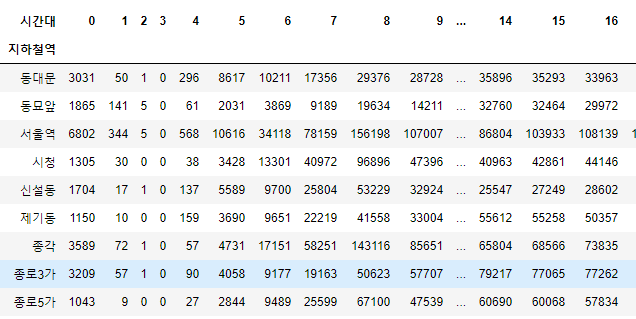

In [47]:
pd.pivot_table(metro_tidy[metro_tidy['호선명']=='1호선'], index = '지하철역', values ='인원수', columns ='시간대').astype(int)

시간대,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
지하철역,,,,,,,,,,,,,,,,,,,,,
동대문,3031,50,1,0,296,8617,10211,17356,29376,28728,...,35896,35293,33963,34209,34220,29957,23083,19518,17488,12053
동묘앞,1865,141,5,0,61,2031,3869,9189,19634,14211,...,32760,32464,29972,26132,21779,12687,7765,6974,6032,3645
서울역,6802,344,5,0,568,10616,34118,78159,156198,107007,...,86804,103933,108139,126488,173126,113323,80567,79303,61991,30626
시청,1305,30,0,0,38,3428,13301,40972,96896,47396,...,40963,42861,44146,53130,89727,48981,36097,35819,24748,10082
신설동,1704,17,1,0,137,5589,9700,25804,53229,32924,...,25547,27249,28602,35662,48742,29562,19021,17719,15424,8865
제기동,1150,10,0,0,159,3690,9651,22219,41558,33004,...,55612,55258,50357,42837,39637,25452,15316,12812,10509,6201
종각,3589,72,1,0,57,4731,17151,58251,143116,85651,...,65804,68566,73835,96689,161601,98272,69232,74671,62434,30474
종로3가,3209,57,1,0,90,4058,9177,19163,50623,57707,...,79217,77065,77262,79261,94520,70404,44368,45244,38068,17776
종로5가,1043,9,0,0,27,2844,9489,25599,67100,47539,...,60690,60068,57834,62505,80101,50989,30269,24873,18799,8142


# 4. StringMethod 객체에 대해 확인 해보자 

In [100]:
# Series 에 'st'로 시작하는 메소드/속성 확인  ==> str 있다.

In [101]:
print ( [ m for m in dir(pd.Series) if  m.startswith('st') ])

['std', 'str']


In [102]:
# DataFrame 에 'st'로 시작하는 메소드/속성 확인  ==> str 없다

In [103]:
print ( [ m for m in dir(pd.DataFrame) if  m.startswith('st') ])

['stack', 'std', 'style']


In [104]:
#  pd.Series.str 에  어떤 객체이고, 어떤 메소드/속성 이 있는지 확인  

In [105]:
pd.Series.str?

In [106]:
print ( [ m for m in dir(pd.Series.str) if  not m.startswith('_') ])

['capitalize', 'casefold', 'cat', 'center', 'contains', 'count', 'decode', 'encode', 'endswith', 'extract', 'extractall', 'find', 'findall', 'get', 'get_dummies', 'index', 'isalnum', 'isalpha', 'isdecimal', 'isdigit', 'islower', 'isnumeric', 'isspace', 'istitle', 'isupper', 'join', 'len', 'ljust', 'lower', 'lstrip', 'match', 'normalize', 'pad', 'partition', 'repeat', 'replace', 'rfind', 'rindex', 'rjust', 'rpartition', 'rsplit', 'rstrip', 'slice', 'slice_replace', 'split', 'startswith', 'strip', 'swapcase', 'title', 'translate', 'upper', 'wrap', 'zfill']


In [107]:
gen_age =pd.Series (['M35 35-39', 'M40 40-44', 'M45 45-49', 'M50 50-54',
          'M55 55-59', 'M60 60-64', 'M65 65-69', 'M70 70-74',
          'M75 75-79', 'M80 80+', 
          'F35 35-39', 'F40 40-44', 'F45 45-49', 'F50 50-54',
          'F55 55-59', 'F60 60-64', 'F65 65-69', 'F70 70-74',
          'F75 75-79', 'F80 80+'], name = 'gender_age' )
gen_age.head()

0    M35 35-39
1    M40 40-44
2    M45 45-49
3    M50 50-54
4    M55 55-59
Name: gender_age, dtype: object

In [108]:
# 4.1 gen_age에 str Accessor로 접근하여 각 문자열의 길이를 확인하라.
#     사용한 메소드의 signature 확인해봐라 (help, ? 활용)

In [109]:
gen_age.str.len()

0     9
1     9
2     9
3     9
4     9
5     9
6     9
7     9
8     9
9     7
10    9
11    9
12    9
13    9
14    9
15    9
16    9
17    9
18    9
19    7
Name: gender_age, dtype: int64

In [110]:
# 4.2 gen_age에 str Accessor로 접근하여 공백으로 나누어 리스트로 출력해보라

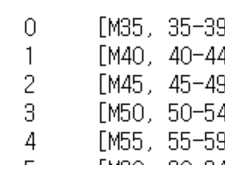

In [111]:
gen_age.str.split(' ')

0     [M35, 35-39]
1     [M40, 40-44]
2     [M45, 45-49]
3     [M50, 50-54]
4     [M55, 55-59]
5     [M60, 60-64]
6     [M65, 65-69]
7     [M70, 70-74]
8     [M75, 75-79]
9       [M80, 80+]
10    [F35, 35-39]
11    [F40, 40-44]
12    [F45, 45-49]
13    [F50, 50-54]
14    [F55, 55-59]
15    [F60, 60-64]
16    [F65, 65-69]
17    [F70, 70-74]
18    [F75, 75-79]
19      [F80, 80+]
Name: gender_age, dtype: object

In [112]:
# 4.3 gen_age에 str Accessor로 접근하여 공백으로 나누고 2개의 컬럼으로 분리하여 
#     DataFrame을 출력하라

In [113]:
gen_age.str.split(' ', expand = True)

,0,1
0,M35,35-39
1,M40,40-44
2,M45,45-49
3,M50,50-54
4,M55,55-59
5,M60,60-64
6,M65,65-69
7,M70,70-74
8,M75,75-79
9,M80,80+


# 5. pd.concat 함수

In [114]:
df1 = pd.DataFrame([[1,'a1'],[2,'b1']], 
                           columns = list('AB'))
df2 = pd.DataFrame([[3,'c2'],[4,'d2']], 
                           columns = list('CD'))
df3 = pd.DataFrame([[5,'b3'],[6,'c3']], 
                           columns = list('BC'))
df1

,A,B
0,1,a1
1,2,b1


In [115]:
df2

,C,D
0,3,c2
1,4,d2


In [116]:
df3

,B,C
0,5,b3
1,6,c3


In [117]:
# 5.1 df1,df2, df3 를 수직으로 pd.concat()으로 연결한다. 
#     아래 2개의 그림과 같이 되도록 매개변수를 조정한다.

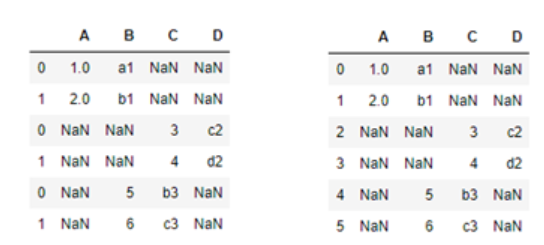

In [118]:
pd.concat([df1,df2,df3], axis = 0)

,A,B,C,D
0,1.0,a1,NaN,NaN
1,2.0,b1,NaN,NaN
0,NaN,NaN,3,c2
1,NaN,NaN,4,d2
0,NaN,5,b3,NaN
1,NaN,6,c3,NaN


In [119]:
pd.concat([df1,df2,df3], axis = 0, ignore_index = True)

,A,B,C,D
0,1.0,a1,NaN,NaN
1,2.0,b1,NaN,NaN
2,NaN,NaN,3,c2
3,NaN,NaN,4,d2
4,NaN,5,b3,NaN
5,NaN,6,c3,NaN


In [120]:
# 5.2 df1,df2, df3 를 수평으로 pd.concat()으로 연결한다. 
#     아래 2개의 그림과 같이 되도록 매개변수를 조정한다.

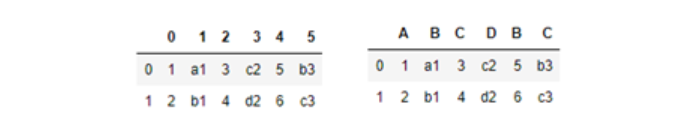

In [121]:
pd.concat([df1,df2,df3],axis =1, ignore_index = True)

,0,1,2,3,4,5
0,1,a1,3,c2,5,b3
1,2,b1,4,d2,6,c3


In [122]:
pd.concat([df1,df2,df3],axis =1)

,A,B,C,D,B,C
0,1,a1,3,c2,5,b3
1,2,b1,4,d2,6,c3


In [123]:
# 5.3 df1과 df3 를 수직/수평으로 pd.concat()으로 연결한다. 
#     그림과 같이 되도록 매개변수를 조정한다.

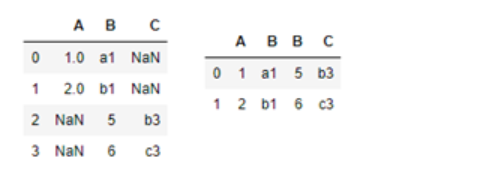

In [124]:
pd.concat([df1,df3], ignore_index = True)

,A,B,C
0,1.0,a1,NaN
1,2.0,b1,NaN
2,NaN,5,b3
3,NaN,6,c3


In [125]:
pd.concat([df1,df3], axis = 1)

,A,B,B,C
0,1,a1,5,b3
1,2,b1,6,c3


# 6. df.merge(), df.join()

In [126]:
df_left = pd.DataFrame({'KEY': ['k0', 'k1', 'k2', 'k3'],
                     'A': ['a0', 'a1', 'a2', 'a3'],
                     'B': ['b0', 'b1', 'b2', 'b3']})
df_right = pd.DataFrame({'KEY': ['k2', 'k3', 'k4', 'k5'],
                     'C': ['c2', 'c3', 'c4', 'c5'],
                     'D': ['d2', 'd3', 'd4', 'd5']})
df_left

,KEY,A,B
0,k0,a0,b0
1,k1,a1,b1
2,k2,a2,b2
3,k3,a3,b3


In [127]:
df_right

,KEY,C,D
0,k2,c2,d2
1,k3,c3,d3
2,k4,c4,d4
3,k5,c5,d5


In [128]:
# 6.1 df_left 에 merge()를 이용해 df_right 병합을 수행하라 (inner join)

In [176]:
pd.merge(df_left, df_right)

,KEY,A,B,C,D
0,k2,a2,b2,c2,d2
1,k3,a3,b3,c3,d3


In [129]:
# 6.2 df_left 에 merge()를 이용해 df_right 병합을 수행하라 (left join)

In [137]:
pd.merge(df_left, df_right, how = 'left')

,KEY,A,B,C,D
0,k0,a0,b0,NaN,NaN
1,k1,a1,b1,NaN,NaN
2,k2,a2,b2,c2,d2
3,k3,a3,b3,c3,d3


In [130]:
# 6.3 df_left 에 merge()를 이용해 df_right 병합을 수행하라 (right join)

In [138]:
pd.merge(df_left, df_right, how = 'right')

,KEY,A,B,C,D
0,k2,a2,b2,c2,d2
1,k3,a3,b3,c3,d3
2,k4,NaN,NaN,c4,d4
3,k5,NaN,NaN,c5,d5


In [ ]:
# 6.4 df_left 에 merge()를 이용해 df_right 병합을 수행하라 (outer join)

In [139]:
pd.merge(df_left, df_right, how = 'outer')

,KEY,A,B,C,D
0,k0,a0,b0,NaN,NaN
1,k1,a1,b1,NaN,NaN
2,k2,a2,b2,c2,d2
3,k3,a3,b3,c3,d3
4,k4,NaN,NaN,c4,d4
5,k5,NaN,NaN,c5,d5


In [140]:
# 6.5 df_left 에 merge()를 이용해 df_right2 병합을 수행하라 (inner join)
df_right2 = pd.DataFrame(
                    { 'B': ['c2', 'c3', 'c4', 'c5'],
                      'E': ['d2', 'd3', 'd4', 'd5'],},
                     index = ['k2', 'k3', 'k4', 'k5'])
df_right2

,B,E
k2,c2,d2
k3,c3,d3
k4,c4,d4
k5,c5,d5


In [189]:
pd.merge(df_left, df_right2, left_on = 'KEY', right_index = True, how = 'inner')

,KEY,A,B_x,B_y,E
2,k2,a2,b2,c2,d2
3,k3,a3,b3,c3,d3


In [ ]:
# 6.6 df_left에 join()을 이용해서 df_right2 결합을 수행하라, 
#    겹치는 컬럼에 대해서 df_right 에서 온 컬럼을 '_r2' 을 suffix로 부여 한다.

In [188]:
df_left.join(df_right2, rsuffix = '_r2')

,KEY,A,B,B_r2,E
0,k0,a0,b0,NaN,NaN
1,k1,a1,b1,NaN,NaN
2,k2,a2,b2,NaN,NaN
3,k3,a3,b3,NaN,NaN


In [ ]:
# 6.7 df_left에 join()을 이용해서 df_right 결합을 수행하라

In [161]:
df_left.join(df_right, rsuffix='_1')

,KEY,A,B,KEY_1,C,D
0,k0,a0,b0,k2,c2,d2
1,k1,a1,b1,k3,c3,d3
2,k2,a2,b2,k4,c4,d4
3,k3,a3,b3,k5,c5,d5
